In [ ]:
!pip install neuromancer

In [ ]:
from neuromancer.psl.nonautonomous import Actuator
from neuromancer.dataset import DictDataset
# instantiate simulator model to be controlled - this mode represent an emulator of a controlled system
sys = Actuator()

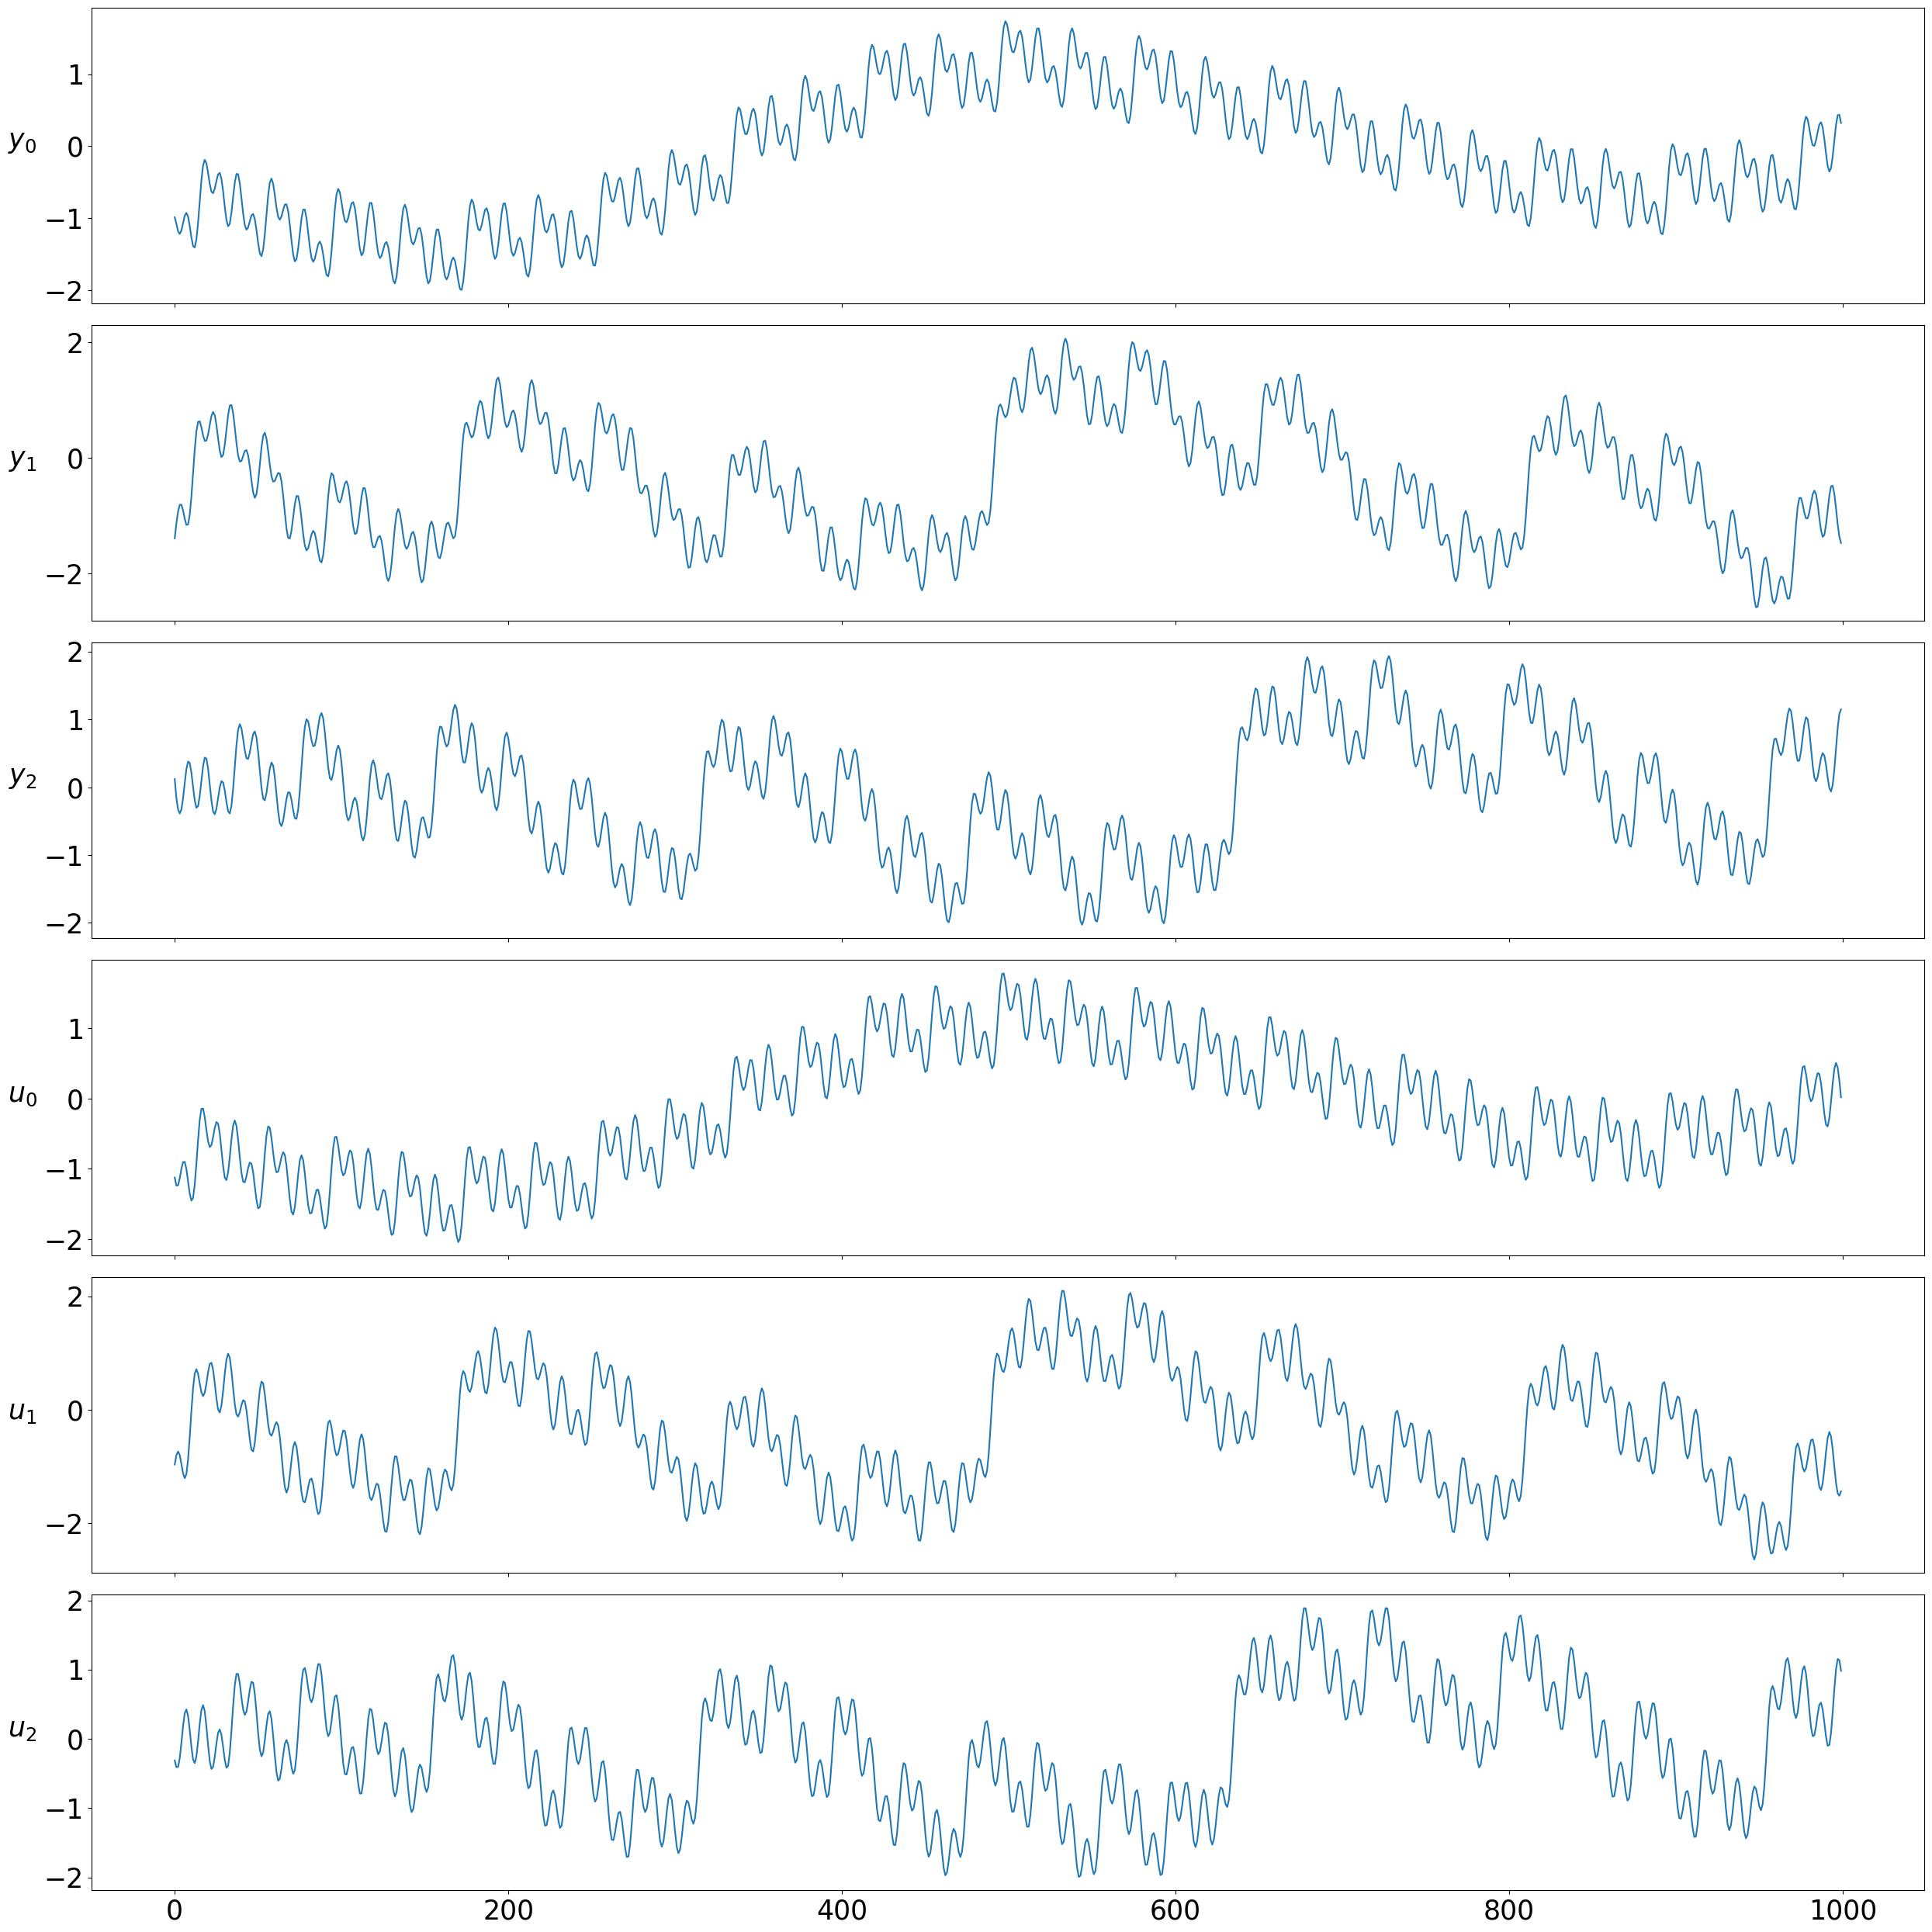

In [ ]:
# obtain time series of the system to be controlled
train_data, dev_data, test_data = [sys.simulate(nsim=1000) for i in range(3)]

# normalize the dataset
train_data, dev_data, test_data = [sys.normalize(d) for d in [train_data, dev_data, test_data]]
# show the training data
# sys.show(train_data)

In [ ]:
# Set up the data to be in samples of 10 contiguous time steps
# (100 samples with 10 time steps each last dim is dimension of the measured variable)
for d in [train_data, dev_data]:
    d['X'] = d['X'].reshape(100, 10, 3)
    d['U'] = d['U'].reshape(100, 10, 3)
    d['Y'] = d['Y'].reshape(100, 10, 3)
    d['xn'] = d['X'][:, 0:1, :] # Add an initial condition to start the system loop
    d['Time'] = d['Time'].reshape(100, -1)

# create dataloaders
from torch.utils.data import DataLoader
train_dataset, dev_dataset, = [DictDataset(d, name=n) for d, n in zip([train_data, dev_data], ['train', 'dev'])]
train_loader, dev_loader = [DataLoader(d, batch_size=100, collate_fn=d.collate_fn, shuffle=True)
                            for d in [train_dataset, dev_dataset]]

In [ ]:
from neuromancer.system import Node, System
from neuromancer.modules import blocks
from neuromancer.dynamics import integrators
import torch

# define neural ODE (NODE)
MLP = blocks.MLP(sys.nx + sys.nu, sys.nx, bias=True, linear_map=torch.nn.Linear, nonlin=torch.nn.ELU,
              hsizes=[20 for h in range(3)])

system_node = Node(MLP, ['xn', 'U'], ['xn'])
model = System([system_node])
# model.show()

In [ ]:
from neuromancer.constraint import variable
from neuromancer.problem import Problem
from neuromancer.loss import PenaltyLoss

# Nstep rollout predictions from the model
xpred = variable('xn')[:, :-1, :]
# Ground truth data
xtrue = variable('X')
# define system identification loss function
loss = (xpred == xtrue) ^ 2
loss.update_name('loss')

# construct differentiable optimization problem in Neuromancer
obj = PenaltyLoss([loss], [])
problem = Problem([model], obj)

In [ ]:
from neuromancer.trainer import Trainer
import torch.optim as optim

opt = optim.AdamW(model.parameters(), 0.001)
trainer = Trainer(problem, train_loader, dev_loader, dev_loader,
                  optimizer=opt,
                  epochs=2000,
                  patience=300,
                  train_metric='train_loss',
                  eval_metric='dev_loss')
best_model = trainer.train()

epoch: 0  train_loss: 0.0019021591870114207
epoch: 1  train_loss: 0.0018360440153628588
epoch: 2  train_loss: 0.0024035784881561995
epoch: 3  train_loss: 0.0019031085539609194
epoch: 4  train_loss: 0.0020960858091712
epoch: 5  train_loss: 0.001991579309105873
epoch: 6  train_loss: 0.0019003383349627256
epoch: 7  train_loss: 0.0018602010095492005
epoch: 8  train_loss: 0.0018238291377201676
epoch: 9  train_loss: 0.0018461087020114064
epoch: 10  train_loss: 0.0018417643150314689
epoch: 11  train_loss: 0.0017573432996869087
epoch: 12  train_loss: 0.0017073010094463825
epoch: 13  train_loss: 0.0017369493143633008
epoch: 14  train_loss: 0.0017458755755797029
epoch: 15  train_loss: 0.0016979256179183722
epoch: 16  train_loss: 0.0016606710851192474
epoch: 17  train_loss: 0.0016578583745285869
epoch: 18  train_loss: 0.0016505203675478697
epoch: 19  train_loss: 0.001629573293030262
epoch: 20  train_loss: 0.0016128504648804665
epoch: 21  train_loss: 0.0015983820194378495
epoch: 22  train_loss: 0.

{'Y': (1000, 3), 'X': (1000, 3), 'U': (1000, 3), 'Time': (1000,)}


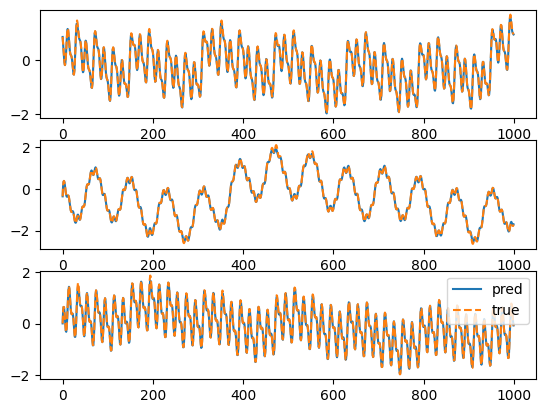

In [ ]:
import torch
test_data = sys.normalize(sys.simulate(nsim=1000))
print({k: v.shape for k, v in test_data.items()})

test_data['X'] = test_data['X'].reshape(1, *test_data['X'].shape)
test_data['U'] = test_data['U'].reshape(1, *test_data['U'].shape)
test_data['xn'] = test_data['X'][:, 0:1, :]
test_data = {k: torch.tensor(v, dtype=torch.float32) for k, v in test_data.items()}
test_output = model(test_data)

import matplotlib.pyplot as plt
fix, ax = plt.subplots(nrows=3)
for v in range(3):
    ax[v].plot(test_output['xn'][0, :-1, v].detach().numpy(), label='pred')
    ax[v].plot(test_data['X'][0, :, v].detach().numpy(), '--', label='true')
plt.legend()

In [ ]:
!git clone https://github.com/Tim-Salzmann/l4casadi.git
%cd /content/l4casadi
!pip install -r requirements_build.txt
!pip install . --no-build-isolation

Cloning into 'l4casadi'...
remote: Enumerating objects: 694, done.
remote: Counting objects: 100% (179/179), done.
remote: Compressing objects: 100% (97/97), done.
remote: Total 694 (delta 101), reused 117 (delta 74), pack-reused 515 (from 1)
Receiving objects: 100% (694/694), 27.13 MiB | 25.01 MiB/s, done.
Resolving deltas: 100% (358/358), done.


In [ ]:
import casadi as ca
import l4casadi as l4c
import torch
import numpy as np

In [ ]:
l4c_model = l4c.L4CasADi(MLP)
# Define symbolic input
x_sym = ca.MX.sym('x', 1, 3)
u_sym = ca.MX.sym('u', 1, 3)
x_u_sym = ca.horzcat(x_sym, u_sym)
# Compute symbolic output
y_sym = l4c_model(x_u_sym).reshape((-1, 1))

# Create the CasADi function
f = ca.Function('y', [x_u_sym], [y_sym])

In [23]:
nx = 3
nu = 3
def mpc_implement(x0, x_ref):
    x0 = x0.numpy().reshape(nx, 1)
    x_ref = x_ref.numpy().reshape(nx, 1)
    Q = ca.DM([[100.0, 0., 0.], [0., 100., 0.], [0., 0., 100.]])
    R = ca.DM([[1.0, 0., 0.], [0., 1., 0.], [0., 0., 1.]])
    u_min = -4.0, -4.0, -4.0
    u_max = 4.0, 4.0, 4.0
    x_min = -4.0, -4.0, -4.0
    x_max = 4.0, 4.0, 4.0
    mpc_horizon = 15

    # Create optimization problem
    opti = ca.Opti()
    X_ca = opti.variable(nx, mpc_horizon + 1)
    U_ca = opti.variable(nu, mpc_horizon)

    # Initial state constraint
    opti.subject_to(X_ca[:, 0] == x0)

    # Objective function
    cost_func = 0
    for k in range(mpc_horizon):
        x_k = X_ca[:, k]
        u_k = U_ca[:, k]
        x_next_k = X_ca[:, k + 1]
        cost_func += ca.mtimes([(x_k - x_ref).T, Q, (x_k - x_ref)]) + ca.mtimes([u_k.T, R, u_k])
        xu_k = ca.vertcat(x_k, u_k)
        # print(f(xu_k).shape)
        opti.subject_to(x_next_k == f(xu_k))
        opti.subject_to(u_min <= u_k)
        opti.subject_to(u_k <= u_max)
        opti.subject_to(x_min <= x_k)
        opti.subject_to(x_k <= x_max)

    cost_func += ca.mtimes([(X_ca[:, -1] - x_ref).T, Q, (X_ca[:, -1] - x_ref)])
    opti.minimize(cost_func)

    # Solver options
    solver_opts = {
    'ipopt': {
        'hessian_approximation': 'limited-memory',  # Use L-BFGS approximation
        'max_iter': 1000,
        'print_level': 0
          },
          'print_time': 0
      }
    opti.solver('ipopt', solver_opts)


    try:
        sol = opti.solve()
        X_opt = sol.value(X_ca)
        U_opt = sol.value(U_ca)
    except RuntimeError:
        X_opt = opti.debug.value(X_ca)
        U_opt = opti.debug.value(U_ca)
    output = torch.tensor(U_opt[:, 0], dtype=torch.float32).reshape(1, 3)
    return output

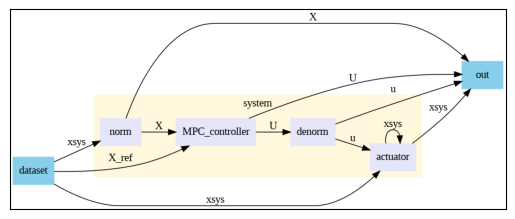

In [24]:
sys.change_backend('torch')
def norm(x):
    return sys.normalize(x, key='X')

def denorm(u):
    return sys.denormalize(u, key='U')

mpc_node = Node(mpc_implement, ['X', 'X_ref'], ['U'], name='MPC_controller')
normnode = Node(norm, ['xsys'], ['X'], name='norm')
denormnode = Node(denorm, ['U'], ['u'], name='denorm')
sysnode = Node(sys, ['xsys', 'u'], ['xsys'], name='actuator')
test_system = System([normnode, mpc_node, denormnode, sysnode])
test_system.show()

In [25]:
from neuromancer.psl.signals import sines, step, arma, spline
import numpy as np

# generate random sequence of step changes
references = step(nsim=1000, d=sys.nx, min=sys.stats['X']['min'], max=sys.stats['X']['max'])
test_data = {'X_ref': torch.tensor(sys.normalize(references, key='X'), dtype=torch.float32).unsqueeze(0), 'xsys': sys.get_x0().reshape(1, 1, -1),
            'Time': (np.arange(1000)*sys.ts).reshape(1, 1000, 1)}
print({k: v.shape for k, v in test_data.items()})
test_system.nsteps=1000
with torch.no_grad():
    test_out = test_system(test_data)

print({k: v.shape for k, v in test_out.items()})

{'X_ref': torch.Size([1, 1000, 3]), 'xsys': torch.Size([1, 1, 3]), 'Time': (1, 1000, 1)}


/usr/local/lib/python3.10/dist-packages/torchdiffeq/_impl/misc.py:15: UserWarning: Dopri5Solver: Unexpected arguments {'grid_points': tensor([0.0000, 0.1000]), 'eps': 1e-06}
  warnings.warn('{}: Unexpected arguments {}'.format(solver.__class__.__name__, unused_kwargs))
/usr/local/lib/python3.10/dist-packages/neuromancer/psl/base.py:105: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  return self.B.cast(method_output, dtype=self.B.core.float32)


{'X_ref': torch.Size([1, 1000, 3]), 'xsys': torch.Size([1, 1001, 3]), 'Time': (1, 1000, 1), 'X': torch.Size([1, 1000, 3]), 'U': torch.Size([1, 1000, 3]), 'u': torch.Size([1, 1000, 3])}


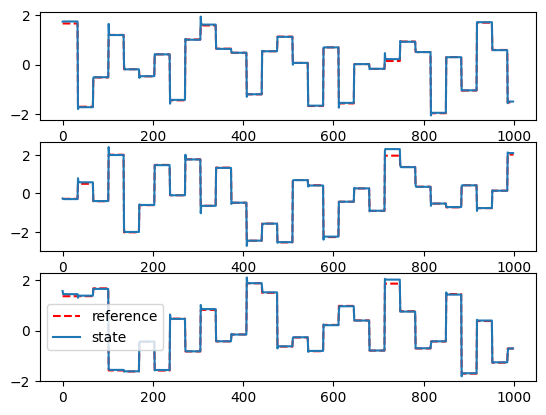

In [26]:
import matplotlib.pyplot as plt
fix, ax = plt.subplots(nrows=3)
for v in range(3):
    ax[v].plot(test_data['X_ref'][0, :, v].detach().numpy(), 'r--', label='reference')
    ax[v].plot(test_out['X'][0, 1:, v].detach().numpy(), label='state')
plt.legend()
# plt.savefig('control.png')
plt.show()